In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cProfile

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer

import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import cv2 as cv2
from skimage.color import rgb2gray
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.filters import gabor_kernel, gabor
from skimage import img_as_float32
from skimage.transform import resize

from joblib import Parallel, delayed


In [2]:
train = pd.read_csv('mnist_train.csv')
test  = pd.read_csv('mnist_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


# Preprocessing

### One hot encoding

In [3]:
encoder = OneHotEncoder()

train_target = train['label']
test_target = test['label']

train_values = train.drop('label', axis=1)
test_values = test.drop('label', axis=1)

train_values = train_values.values.reshape(-1, 28, 28) 
test_values = test_values.values.reshape(-1, 28, 28)

train_target_encoded = encoder.fit_transform(train_target.values.reshape(-1, 1)).toarray()
test_target_encoded = encoder.transform(test_target.values.reshape(-1, 1)).toarray()

print("Shape of train_values:", train_values.shape)
print("Shape of train_target_encoded:", train_target_encoded.shape)

print("Shape of test_values:", test_values.shape)
print("Shape of test_target_encoded:", test_target_encoded.shape)

Shape of train_values: (60000, 28, 28)
Shape of train_target_encoded: (60000, 10)
Shape of test_values: (10000, 28, 28)
Shape of test_target_encoded: (10000, 10)


In [4]:
X_train = train_values
X_train = train_values.astype(np.uint8)

y_train_ENC = train_target_encoded
y_train = np.argmax(y_train_ENC, axis=1)

X_test = test_values
X_test = test_values.astype(np.uint8)

y_test_ENC = test_target_encoded
y_test = np.argmax(y_test_ENC, axis=1)

### Normalizacja histogramem

In [5]:
# # Sprawdzenie i konwersja typu danych
# if X_train.dtype != np.uint8:
#     X_train = X_train.astype(np.float32)
# if X_test.dtype != np.uint8:
#     X_test = X_test.astype(np.float32)

# Sprawdzenie i ewentualna korekta kształtu danych
if X_train.shape[1:] != (28, 28):
    X_train = X_train.reshape(-1, 28, 28)
if X_test.shape[1:] != (28, 28):
    X_test = X_test.reshape(-1, 28, 28)

# Wyrównywanie histogramu
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])

### Powiększanie i wygładzenie obrazu

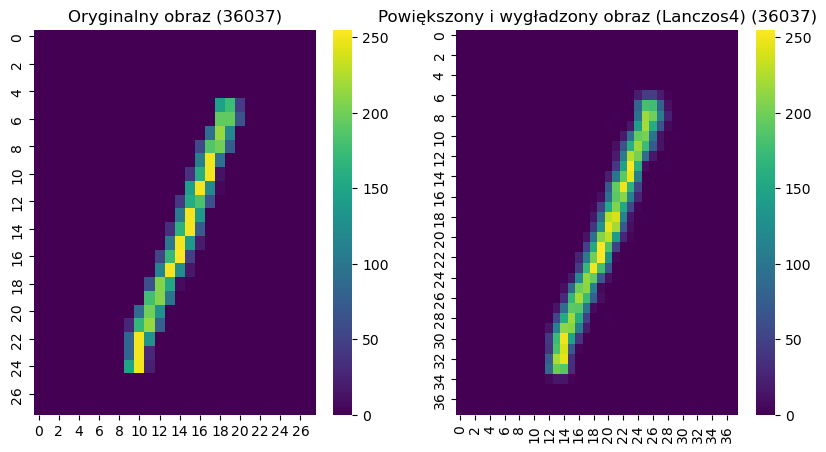

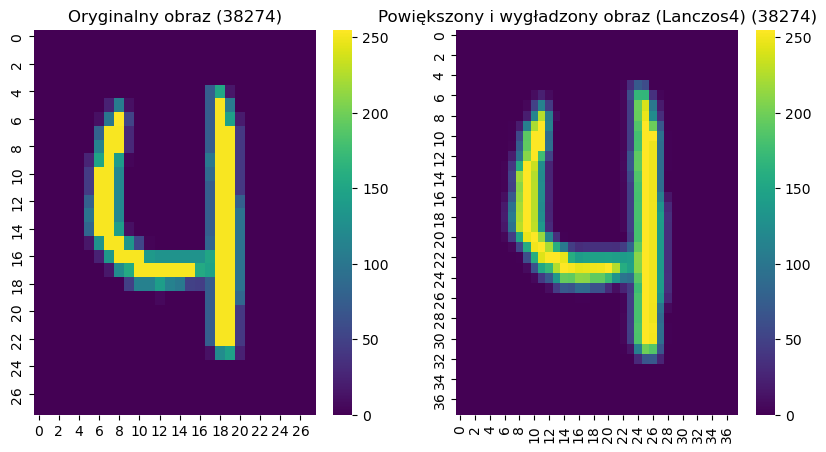

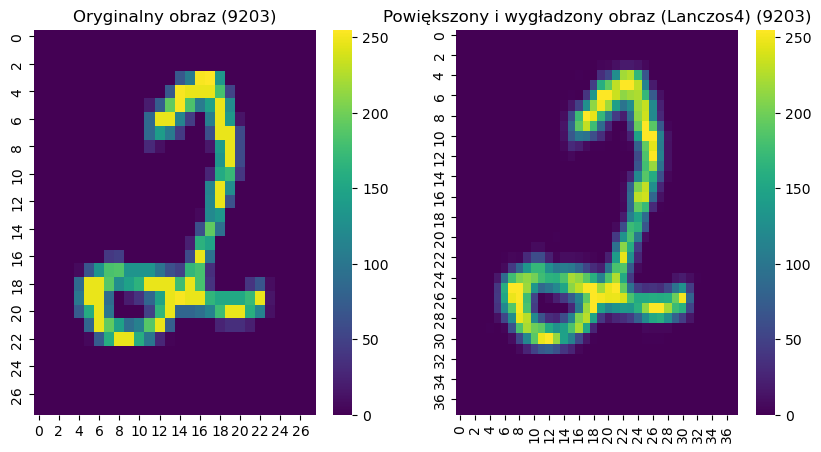

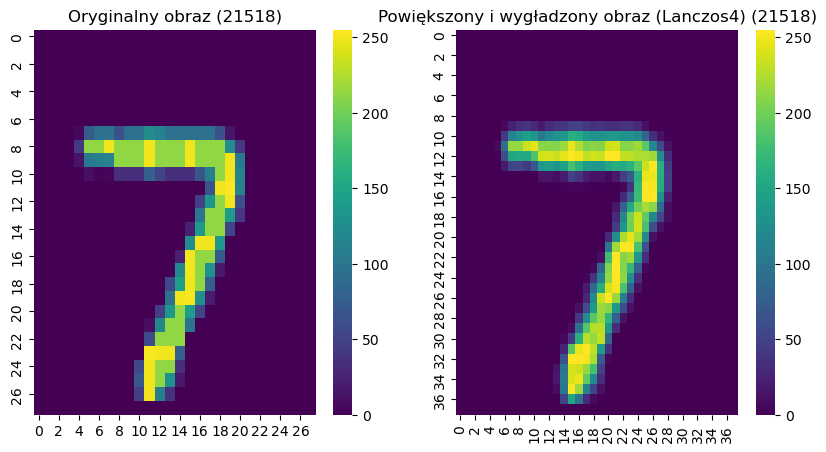

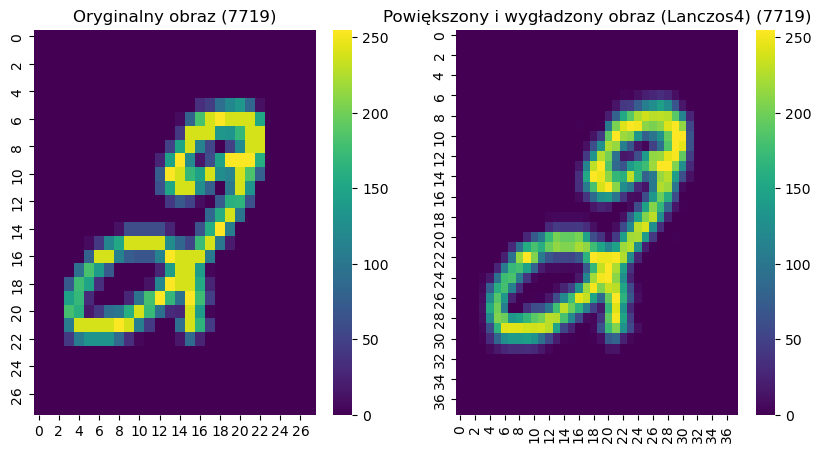

In [6]:
def enlarge_and_smooth(image, new_size):
    """Powiększa obraz za pomocą interpolacji bicubic."""
    enlarged_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return enlarged_image

# Sztuczne zwiększenie rozmiaru obrazu 
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

# Dla każdego wybranego obrazu
for idx in sample_indices:
    # Oryginalny obraz
    original_image = X_train[idx]

    # Powiększony i wygładzony obraz
    enlarged_smoothed_image = enlarge_and_smooth(original_image, new_size=(42, 42))  # Przykładowy nowy rozmiar

    # Wyświetl oryginalny i przekształcony obraz obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.heatmap(original_image, cmap="viridis", ax=axes[0])
    axes[0].set_title(f'Oryginalny obraz ({idx})')

    sns.heatmap(enlarged_smoothed_image, cmap="viridis", ax=axes[1])
    axes[1].set_title(f'Powiększony i wygładzony obraz (Lanczos4) ({idx})')

    #plt.show()

### Sprawdzenie modelu wykorzystując SVC

In [7]:
# # Baseline accuracy without transformations
# X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

# qda_base = QDA()
# qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for QDA
# y_pred_qda_base = qda_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_qda_base = accuracy_score(y_val_base, y_pred_qda_base)

# svm_base = SVC()
# svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for SVM
# y_pred_svm_base = svm_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_svm_base = accuracy_score(y_val_base, y_pred_svm_base)

# print("Baseline QDA accuracy:", accuracy_qda_base)
# print("Baseline SVM accuracy:", accuracy_svm_base)

Baseline QDA accuracy: 0.5525


Baseline SVM accuracy: 0.9793

# Deklaracja funkcji dla ekstrakcji cech z obrazu

In [8]:

def calculate_hog_parallel(images, orientations=None, pixels_per_cell=None, cells_per_block=None, n_jobs=-1):
    """Oblicza deskryptory HOG dla obrazu."""
    
     # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if orientations is None:
        orientations = 9
    if pixels_per_cell is None:
        pixels_per_cell = (8, 8)
    if cells_per_block is None:
        cells_per_block = (2, 2)
    
    def calculate_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block):
        
        image = img_as_float32(image)

        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block, visualize=False, channel_axis=None)

        return fd
    
    return Parallel(n_jobs=n_jobs)(delayed(calculate_hog)(image, orientations, pixels_per_cell, cells_per_block) for image in images)


def apply_gabor_filters_parallel(images, thetas=None, sigmas=None, frequencies=None, n_jobs=-1):
    """
    Stosuje filtry Gabora do wielu obrazów równolegle.

    Argumenty:
        images: Lista obrazów wejściowych.
        thetas: (Opcjonalnie) Lista kątów orientacji filtrów Gabora (w radianach). Jeśli None, używane są wartości domyślne.
        sigmas: (Opcjonalnie) Lista odchyleń standardowych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        frequencies: (Opcjonalnie) Lista częstotliwości przestrzennych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        n_jobs: Liczba rdzeni procesora do wykorzystania podczas zrównoleglania. -1 oznacza użycie wszystkich dostępnych rdzeni.

    Zwraca:
        Listę tablic NumPy zawierających obrazy przefiltrowane filtrami Gabora, o typie danych float32.
    """

    # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if thetas is None:
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    if sigmas is None:
        sigmas = [1, 3]
    if frequencies is None:
        frequencies = [0.05, 0.25]

    def apply_gabor_filters_single(image):
        image = img_as_float32(image)
        filtered_images = [gabor(image, frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)[0]
                           for theta in thetas for sigma in sigmas for frequency in frequencies]
        return np.array(filtered_images, dtype=np.float32)

    return Parallel(n_jobs=n_jobs)(delayed(apply_gabor_filters_single)(image) for image in images)


def extract_features_HOG_Gabor(X, hog_orientations=None, hog_pixels_per_cell=None, hog_cells_per_block=None, 
                              gabor_thetas=None, gabor_sigmas=None, gabor_frequencies=None):
    """Generator zwracający cechy HOG i Gabora dla obrazów."""

    hog_features_list = calculate_hog_parallel(X, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell, cells_per_block=hog_cells_per_block)
    gabor_features_list = apply_gabor_filters_parallel(X, thetas=gabor_thetas, sigmas=gabor_sigmas, frequencies=gabor_frequencies)

    for hog_features, gabor_features in zip(hog_features_list, gabor_features_list):
        
        gabor_features_flattened = np.array([img.flatten() for img in gabor_features])

        # Dopasowujemy kształt hog_features do gabor_features_flattened
        hog_features_reshaped = np.repeat(hog_features.reshape(1, -1), gabor_features_flattened.shape[0], axis=0)

        # Łączymy cechy HOG i Gabora w poziomie
        concatenated_features = np.hstack((hog_features_reshaped, gabor_features_flattened))

        concatenated_features = concatenated_features.flatten()

        yield concatenated_features

#################################################################################################################################################
################################################  Directional filters, ORB    ###################################################################

def apply_directional_filters(image, kernel_sizes=[3, 5, 7]):
    """Stosuje filtry kierunkowe do obrazu."""
    filtered_images = []
    for kernel_size in kernel_sizes:
        kernel_horizontal = cv2.getDerivKernels(1, 0, kernel_size, normalize=True)
        kernel_vertical = cv2.getDerivKernels(0, 1, kernel_size, normalize=True)
        filtered_horizontal = cv2.filter2D(image, cv2.CV_32F, kernel_horizontal[0])
        filtered_vertical = cv2.filter2D(image, cv2.CV_32F, kernel_vertical[0])
        filtered_images.append(filtered_horizontal.flatten())
        filtered_images.append(filtered_vertical.flatten())
        if kernel_size % 2 == 0 or kernel_size > 31:
            raise ValueError(f"Nieprawidłowy rozmiar jądra: {kernel_size}. Rozmiar jądra musi być nieparzysty i nie większy niż 31.")
    return np.array(filtered_images).squeeze()

def extract_orb_features(image, nfeatures=500):
    """Wyodrębnia cechy ORB z obrazu."""
    orb = cv2.ORB_create(nfeatures=nfeatures)  
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros(nfeatures * 32)  
    return descriptors.flatten()



#################################################################################################################################################
################################################  GLCM, Zernike    ##############################################################################
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'energy', 'homogeneity', 'correlation']):
    """Wyodrębnia cechy GLCM z obrazu."""
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in properties:
        features.extend(graycoprops(glcm, prop).flatten())

    return np.array(features)


## Testowanie modelu dla HOG i filtrów Gabora i porównanie wydajności przy zastosowaniu redukcji wymiarów. 

In [9]:
# def train_and_evaluate_models(X_train, y_train, use_pca=True):
#     """
#     Trenuje i ocenia modele QDA i SVC, opcjonalnie z redukcją wymiarów PCA.

#     Argumenty:
#         X_train: Dane treningowe.
#         y_train: Etykiety treningowe.
#         use_pca: Flaga wskazująca, czy używać PCA (domyślnie True).
#     """

#     # Ekstrakcja cech HOG i Gabor za pomocą generatora
#     X_train_features = np.array(list(extract_features_HOG_Gabor(X_train)))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)

#     # Redukcja wymiarów (opcjonalnie)
#     if use_pca:
#         pca_dim = PCA(n_components=50)
#         X_train = pca_dim.fit_transform(X_train)
#         X_val = pca_dim.transform(X_val)

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train, y_train)

#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train, y_train)

#     # Ocena modelu
#     y_pred_qda = qda.predict(X_val)
#     accuracy_qda = accuracy_score(y_val, y_pred_qda)

#     y_pred_svc = svc.predict(X_val)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)

#     print("Dokładność QDA HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_qda)
#     print("Dokładność SVC HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_svc)

# # Test z PCA
# train_and_evaluate_models(X_train, y_train, use_pca=True)
#train_and_evaluate_models(X_train, y_train, use_pca=False)
#cProfile.run('train_and_evaluate_models(X_train, y_train, use_pca=True)') 

Dokładność QDA HOG i Gabor       : 0.5734


Dokładność SVC HOG i Gabor       : 0.987





Dokładność QDA HOG i Gabor po PCA: 0.9701


Dokładność SVC HOG i Gabor po PCA: 0.9869

Czas obliczeń dla PCA 3min vs 30min bez PCA

## OPTUNA dla HOG, Gabor, PCA

In [10]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")


# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """

#     # Parametry HOG
#     orientations      = trial.suggest_int("hog_orientations", 2, 16)
#     pixels_per_cell   = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     cells_per_block   = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas      = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas      = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
#     kernel = trial.suggest_categorical("kernel_pca_kernel", ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'])
#     gamma = None
#     if kernel in ['poly', 'rbf']:
#         gamma = trial.suggest_loguniform("kernel_pca_gamma", 0.001, 1)
        
#     # Powiększanie i wygładzanie
#     # X_train_split = np.array([enlarge_and_smooth(img, new_size) for img in X_train])
#     # X_val = np.array([enlarge_and_smooth(img, new_size) for img in X_val])
    
#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=orientations, 
#         hog_pixels_per_cell=eval(pixels_per_cell), # Konwersja stringa na krotkę
#         hog_cells_per_block=eval(cells_per_block),  # Konwersja stringa na krotkę
#         gabor_thetas=gabor_thetas, 
#         gabor_sigmas=gabor_sigmas, 
#         gabor_frequencies=gabor_frequencies
#     )))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)
    
    
#     # Kernel PCA
#     kpca = KernelPCA(n_components=PCA_n_components, kernel=kernel, gamma=gamma)
#     X_train_reduced = kpca.fit_transform(X_train_filters)
#     X_val_reduced = kpca.transform(X_val_filters)
                
#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_filters)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val_filters, y_pred_svm)

#     return accuracy_svm

# # Optymalizacji
                            
# study = optuna.create_study(directions=["maximize"], sampler=optuna.samplers.CmaEsSampler() ) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=1)


# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

# # [I 2024-09-17 05:43:37,964] Trial 13 finished with value: 0.99133 and parameters: {'hog_orientations': 16, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(3, 3)', 'gabor_thetas': [0.2243994752564138], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.025], 'PCA_Components': 209, 'kernel_pca_kernel': 'cosine'}. Best is trial 13 with value: 0.9913333333333333.
# # [I 2024-09-17 08:45:58,345] Trial 19 finished with value: 0.99175 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(2, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.025], 'PCA_Components': 132, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 19 with value: 0.99175.
# # [I 2024-09-17 10:45:29,605] Trial 23 finished with value: 0.99225 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(3, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 150, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:24:59,082] Trial 28 finished with value: 0.99108 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0, 0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 190, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:54:44,248] Trial 29 finished with value: 0.9915 and parameters: {'hog_orientations': 7, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05], 'PCA_Components': 164, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 18:02:03,444] Trial 37 finished with value: 0.99066 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05, 0.175], 'PCA_Components': 169, 'kernel_pca_kernel': 'rbf', 'kernel_pca_gamma': 0.0032186977490984547}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 19:02:58,946] Trial 39 finished with value: 0.9915 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [1, 3], 'gabor_frequencies': [0.125], 'PCA_Components': 148, 'kernel_pca_kernel': 'linear'}. Best is trial 23 with value: 0.99225.


### Wykorzystanie wcześniej otrzymanch hiperparamatrów dla HOG i filtrów Gabora po KPCA w celu stworzenia wektora cech z obrazów.

In [11]:
# X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=6, 
#         hog_pixels_per_cell=eval('(3, 3)'), 
#         hog_cells_per_block=eval('(2, 2)'),  
#         gabor_thetas=[0], 
#         gabor_sigmas=[1], 
#         gabor_frequencies=[0.05, 0.25]
#     )))


# kpca = KernelPCA(n_components=150, kernel='cosine')

# X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train_ENC, test_size=0.2, random_state=69)

# X_train_reduced = kpca.fit_transform(X_train_filters)
# X_val_reduced = kpca.transform(X_val_filters)


# np.save('X_train_reduced.npy', X_train_reduced)
# np.save('X_val_reduced.npy', X_val_reduced)
# np.save('y_train_filters.npy', y_train_filters)
# np.save('y_val_filters.npy', y_val_filters)


#### Pierwszy model na sieci konwolucyjnej dla bazy z HOG i Gabora.

In [12]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization , BatchNormalization, PReLU , Input, ActivityRegularization, GlobalAveragePooling1D, SeparableConv1D 
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Lion
# from tensorflow.keras.callbacks import EarlyStopping
# import gc



# X_train_reduced = np.load('X_train_reduced.npy')
# X_val_reduced = np.load('X_val_reduced.npy')
# y_train_filters = np.load('y_train_filters.npy')
# y_val_filters = np.load('y_val_filters.npy')

# X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
# X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

# def calculate_max_pool_size(input_length, prev_pool_size, min_output_size=2):
#     calculated_pool_size = input_length // prev_pool_size
#     return max(min_output_size, calculated_pool_size)


# def objective(trial):
#     """Funkcja celu dla Optuny."""
#     #os.environ['TF_NUM_INTRAOP_THREADS'] = '1' ## Czy Kers działa na pojedycznym wątku ????
#     gc.collect()
#     tf.keras.backend.clear_session()
#     gc.collect()

#     activation_functions = ['relu', 'elu', 'leaky_relu', 'tanh']
#     activation = trial.suggest_categorical('activation', activation_functions)

#     # Definiowanie modelu
#     model = Sequential()
#     model.add(Input(shape=(X_train_reduced.shape[1], 1)))

#     # Pierwsza warstwa konwolucyjna
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_1', 48, 450),
#                      kernel_size=trial.suggest_int('kernel_size_1', 2, 16),
#                      #activation=activation,
#                      padding='same', 
#                      #dilation_rate=trial.suggest_int('dilation_rate_1', 1, 4)
#                      )
#               )
#     model.add(PReLU())                #$$$$$$$ LAYER przed PRelu
#     model.add(LayerNormalization())   ######
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_1 = trial.suggest_int('pool_size_1', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_1))



#     # Druga warstwa konwolucyjna
#     input_length_2 = X_train_reduced.shape[1] // pool_size_1
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_2', 24, 400),
#                      kernel_size=trial.suggest_int('kernel_size_2', 2, 14),
#                      padding='same',
#                      #activation=activation,
#                      #dilation_rate=trial.suggest_int('dilation_rate_2', 1, 4)
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_2 = trial.suggest_int('pool_size_2', 2, input_length_2 // 2)
#     #pool_size_2 = trial.suggest_int('pool_size_2', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_2))



#     # Trzecia warstwa konwolucyjna
#     #input_length_3 = input_length_2 // pool_size_2
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_3', 32, 300),
#                      kernel_size=trial.suggest_int('kernel_size_3', 2, 12),
#                      padding='same',
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_3', 0.01, 0.5)
#                       )
#               )
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, max(2, input_length_3 // 2))
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, 8)
#     #model.add(MaxPooling1D(pool_size=pool_size_3))

#     # Warstwy Dense
#     model.add(GlobalAveragePooling1D())
    
#     model.add(Dense(units=trial.suggest_int('dense_units_1', 40, 300), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_4', 0.01, 0.75)))
    
#     model.add(Dense(units=trial.suggest_int('dense_units_2', 20, 200), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_5', 0.01, 0.65)))
    
#     model.add(Dense(10, activation='softmax'))

#     # Optymalizator
#     lr_initial = trial.suggest_float("lr_initial", 1e-5, 1e-1, log=True)
#     decay_steps = trial.suggest_int("decay_steps", 10, 150)
#     decay_rate = trial.suggest_float("decay_rate", 0.01, 0.99)
#     lr_schedule = ExponentialDecay(initial_learning_rate=lr_initial,
#                                   decay_steps=decay_steps,
#                                   decay_rate=decay_rate)

#     optimizer_name = trial.suggest_categorical('optimizer', ['Lion'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
#     optimizer = optimizer_class(learning_rate=lr_schedule)

    
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=16, start_from_epoch=10, min_delta = 0.00005)

#     # Trenowanie modelu
#     model.fit(X_train_reduced, y_train_filters,
#               epochs=trial.suggest_int('epochs', 40, 150),
#               batch_size=trial.suggest_int('batch_size', 64, 1920),
#               validation_data=(X_val_reduced, y_val_filters),
#               verbose=1,
#               callbacks=[early_stopping])

#     # Ewaluacja modelu
#     _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)

#     del model
#     return accuracy

# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)

# #[I 2024-10-04 05:18:28,377] Trial 26 finished with value: 0.9810000061988831 and parameters: {'activation': 'elu', 'conv1d_filters_1': 347, 'kernel_size_1': 7,  'l1_1': 0.0002141584459916536, 'l2_1': 4.201061472934882e-06, 'pool_size_1': 6, 'conv1d_filters_2': 77, 'kernel_size_2': 14, 'l1_2': 3.203529032832527e-06, 'l2_2': 0.00015793896479891322, 'pool_size_2': 2, 'conv1d_filters_3': 258, 'kernel_size_3': 4, 'dropout_rate_3': 0.3297488074504043, 'dense_units_1': 271, 'dropout_rate_4': 0.5097723961373417, 'dense_units_2': 78, 'dropout_rate_5': 0.15473996425601394, 'lr_initial': 0.0004175922071628326, 'decay_steps': 33, 'decay_rate': 0.9780884395210858, 'optimizer': 'Lion', 'epochs': 123, 'batch_size': 264}. Best is trial 26 with value: 0.9810000061988831.
# #[I 2024-10-04 14:58:14,236] Trial 61 finished with value: 0.9797499775886536 and parameters: {'activation': 'elu', 'conv1d_filters_1': 424, 'kernel_size_1': 13, 'l1_1': 0.0005501543495144062, 'l2_1': 0.02794377888054429,   'pool_size_1': 7, 'conv1d_filters_2': 79, 'kernel_size_2': 12, 'l1_2': 1.3699264627909325e-06, 'l2_2': 6.577814668979489e-06, 'pool_size_2': 3, 'conv1d_filters_3': 280, 'kernel_size_3': 3, 'dropout_rate_3': 0.21341586312675653, 'dense_units_1': 292, 'dropout_rate_4': 0.22415600475665626, 'dense_units_2': 106, 'dropout_rate_5': 0.09686035013603865, 'lr_initial': 0.0004430745906851504, 'decay_steps': 22, 'decay_rate': 0.9872365423551039, 'optimizer': 'Lion', 'epochs': 150, 'batch_size': 216}. Best is trial 26 with value: 0.9810000061988831.


#### Drugi model na GRU

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM , GRU , LayerNormalization, PReLU, ActivityRegularization, Dense, GlobalAveragePooling1D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import optuna


# X_train_reduced = np.load('X_train_reduced.npy')
# X_val_reduced = np.load('X_val_reduced.npy')
# y_train_filters = np.load('y_train_filters.npy')
# y_val_filters = np.load('y_val_filters.npy')

# X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
# X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

# def objective(trial):
    
#     Inp = Input(shape=(X_train_reduced.shape[1], 1))

#     x = PReLU()(Inp)
#     x = GRU(
#         units=trial.suggest_int('units_1', 24, 600),
#         activation='silu',
#         return_sequences=True  # Dodano return_sequences=True
#     )(x)
#     x = LayerNormalization()(x)
#     x = ActivityRegularization(
#         l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True),
#         l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
#     )(x)

#     x = PReLU()(x)
#     x = GRU(
#         units=trial.suggest_int('units_2', 24, 600),
#         activation='silu'
#     )(x)
#     x = LayerNormalization()(x)
#     x = ActivityRegularization(
#         l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True),
#         l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
#     )(x)

#     x = Dense(units=trial.suggest_int('dense_units', 24, 600), activation='silu')(x)
#     x = Dropout(rate=trial.suggest_float('dropout_rate_last', 0.01, 0.75))(x)
#     outputs = Dense(10, activation='softmax')(x)

#     model = Model(inputs=Inp, outputs=outputs)
#     tf.keras.utils.plot_model(model, to_file='model.png')


#     # ReduceLROnPlateau
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
#         patience=trial.suggest_int("reduce_lr_patience", 2, 12),
#         min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
#     )

#     # Optymalizator
#     optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
#     # Początkową wartość learning rate
#     lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
#     optimizer = optimizer_class(learning_rate=lr_initial)  

#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     #model.summary()

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, start_from_epoch=8, min_delta = 0.0001)
    
#     # Trenowanie modelu
#     model.fit(X_train_reduced, y_train_filters,
#               epochs=trial.suggest_int('epochs', 25, 80),
#               batch_size=trial.suggest_int('batch_size', 64, 1920),
#               validation_data=(X_val_reduced, y_val_filters),
#               verbose=0,
#               callbacks=[early_stopping, reduce_lr])

#     # Ewaluacja modelu
#     _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)
    
    
#     del model
#     return accuracy

# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)   

#### Model bazujący na dwóch potokach danych surowych przechodzących przez Conv2d, oraz LSTM dla danych z HOG i Gabor. Wykorzystanie mechanizmu atencji. 

In [ ]:
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, GlobalAveragePooling1D, Permute, Flatten, Reshape, Conv2D, MaxPooling2D, Concatenate, Attention, Dense, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc
from tensorflow.keras.callbacks import TensorBoard


X_train_reduced = np.load('X_train_reduced.npy')
X_val_reduced = np.load('X_val_reduced.npy')
y_train_filters = np.load('y_train_filters.npy')
y_val_filters = np.load('y_val_filters.npy')

X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
X_train_image = X_train_image.astype('float32')
X_val_image = X_val_image.astype('float32')
X_train_image = np.expand_dims(X_train_image, axis=-1)  
X_val_image = np.expand_dims(X_val_image, axis=-1) 
 

# # Sprawdzenie poprawności danych wejściowych
# print("Kształt X_train_image:", X_train_image.shape)
# print("Kształt X_val_image:", X_val_image.shape)
# print("Kształt X_train_reduced:", X_train_reduced.shape)
# print("Kształt X_val_reduced:", X_val_reduced.shape)

# print("Kształt y_train_filters:", y_train_filters.shape)
# print("Kształt y_val_filters:", y_val_filters.shape)
# print("Kształt y_train_image:", y_train_image.shape)
# print("Kształt y_val_image:", y_val_image.shape)

# # Sprawdzenie typów danych
# print("Typ danych X_train_image:", X_train_image.dtype)
# print("Typ danych X_val_image:", X_val_image.dtype)
# print("Typ danych X_train_reduced:", X_train_reduced.dtype)
# print("Typ danych X_val_reduced:", X_val_reduced.dtype)
# print("Typ danych y_train_filters:", y_train_filters.dtype)
# print("Typ danych y_val_filters:", y_val_filters.dtype)
# print("Typ danych y_train_image:", y_train_image.dtype)
# print("Typ danych y_val_image:", y_val_image.dtype)

def objective(trial):
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()
    units1=trial.suggest_int('units_1', 24, 192)
    units2=trial.suggest_int('units_1', 24, 192)
    l1_1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True)
    l2_1=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
    
    l1_2=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True)
    l2_2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
    
    image_input = Input(shape=X_train_image.shape[1:])
    flattened_input = Input(shape=X_train_reduced.shape[1:])

    # LSTM
    lstm1 = LSTM(units1,
                return_sequences=True,
                activation = 'silu'
                )(flattened_input)
    
    lstm1 = LayerNormalization()(lstm1)
    lstm1 = ActivityRegularization(
                                    l1 = l1_1,
                                    l2 = l2_1
                                  )(lstm1)
    lstm2 = LSTM(units2,
                return_sequences=True,
                activation = 'silu'
                )(lstm1)
    lstm2 = LayerNormalization()(lstm2)
    lstm1 = ActivityRegularization(
                                    l1 = l1_2,
                                    l2 = l2_2 
                                  )(lstm2)
    
    pool_lstm = GlobalAveragePooling1D()(lstm2) 
    flat_lstm = Flatten()(pool_lstm)
    print("flat_lstm shape:", flat_lstm)

    # Gałąź Conv2D
    conv1 = Conv2D(64, kernel_size=(3, 3), activation='silu')(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='silu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  
    flat_cnn = Flatten()(pool2)
    print("flat_cnn shape:", flat_cnn)
    
    # Połączenie gałęzi
    merged = Concatenate()([flat_lstm, flat_cnn])
    print("merged shape:", merged)  # Wydrukuj kształt po połączeniu
    merged = Reshape((merged.shape[1], 1))(merged)

    attention_output = Attention()([merged, merged])
    attention_output = Reshape((attention_output.shape[1],))(attention_output)
    output = Dense(10, activation='softmax')(attention_output)
    model = Model(inputs=[image_input, flattened_input], outputs=output)
    
    tf.keras.utils.plot_model(model, to_file='model.png')
    model.summary()
    

    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
        patience=trial.suggest_int("reduce_lr_patience", 2, 12),
        min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
    )

    # Optymalizator
    optimizer_name = trial.suggest_categorical('optimizer', ['Lion'])
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
    # Początkową wartość learning rate
    lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
    optimizer = optimizer_class(learning_rate=lr_initial)  

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, start_from_epoch=8, min_delta=0.0001)

    tensorboard = TensorBoard(log_dir='./logs')
    
    # Trenowanie modelu
    model.fit(
        [X_train_image, X_train_reduced], 
        y_train_filters,
        epochs=trial.suggest_int('epochs', 25, 80),
        batch_size=trial.suggest_int('batch_size', 64, 1920),
        validation_data=([X_val_image, X_val_reduced], y_val_filters),
        verbose=1,
        callbacks=[early_stopping, reduce_lr, tensorboard]
    )

    # Ewaluacja modelu
    _, accuracy = model.evaluate([X_val_image, X_val_reduced], y_val_filters, verbose=0)  # Poprawione wejście
    
    del model
    return accuracy

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# Najlepsze parametry i wynik
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)



[I 2024-10-06 15:11:53,543] A new study created in memory with name: no-name-b56df21d-0b52-4ff4-b42f-abee8a7c63e2



flat_lstm shape: <KerasTensor shape=(None, 136), dtype=float32, sparse=False, name=keras_tensor_9>
flat_cnn shape: <KerasTensor shape=(None, 1600), dtype=float32, sparse=False, name=keras_tensor_14>
merged shape: <KerasTensor shape=(None, 1736), dtype=float32, sparse=False, name=keras_tensor_15>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 150, 136)  │     75,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 150, 136)  │        272 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_regulariz… │ (None, 150, 136)  │          0 │ layer_normalizat… │
│ (ActivityRegulariz… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 150, 136)  │    148,512 │ activity_regular… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 136)  │        272 │ lstm_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 136)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 136)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1600)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1736)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1736, 1)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1736, 1)   │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1736)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     17,370 │ reshape_1[0][0] 

 Total params: 279,066 (1.06 MB)

 Trainable params: 279,066 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.0986 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0726
Epoch 2/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.1013 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0726
Epoch 3/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.1006 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0726
Epoch 4/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.0979 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0363
Epoch 5/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.1011 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0363
Epoch 6/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.0981 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learning_rate: 0.0363
Epoch 7/48
64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.0973 - loss: nan - val_accuracy: 0.0972 - val_loss: nan - learnin